In [1]:
import datetime
import gc
import random
import time

import numpy
import pandas
import scipy
import matplotlib.pyplot as plt
import IPython.display as disp

class Progress:
    """Wrapper for IPython.display.ProgressBar with improved performance"""

    def __init__(self, total):
        self.bar = disp.ProgressBar(total)
        self.progress = 0
        self.last = 0
    def inc(self):
        self.progress += 1
        if time.monotonic_ns() - self.last > 1e8:
            self.bar.progress = self.progress
            self.bar.update()
            self.last = time.monotonic_ns()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_value, tb):
        self.bar.progress = self.progress
        self.bar.update()
        return False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!test -d dataset || unzip /content/drive/Shareddrives/'STAT4609 Netflix'/dataset.zip -d dataset

Archive:  /content/drive/Shareddrives/STAT4609 Netflix/dataset.zip
  inflating: dataset/README          
  inflating: dataset/combined_data_1.txt  
  inflating: dataset/combined_data_2.txt  
  inflating: dataset/combined_data_3.txt  
  inflating: dataset/combined_data_4.txt  
  inflating: dataset/movie_titles.csv  
  inflating: dataset/probe.txt       
  inflating: dataset/qualifying.txt  


In [4]:
!cp /content/drive/Shareddrives/'STAT4609 Netflix'/preprocess-dataset /usr/local/bin
!chmod +x /usr/local/bin/preprocess-dataset
!test -f dataset/output.npy || (cd dataset && preprocess-dataset)

Read 1000000 lines of probe
Read 1000000 lines
Read 2000000 lines
Read 3000000 lines
Read 4000000 lines
Read 5000000 lines
Read 6000000 lines
Read 7000000 lines
Read 8000000 lines
Read 9000000 lines
Read 10000000 lines
Read 11000000 lines
Read 12000000 lines
Read 13000000 lines
Read 14000000 lines
Read 15000000 lines
Read 16000000 lines
Read 17000000 lines
Read 18000000 lines
Read 19000000 lines
Read 20000000 lines
Read 21000000 lines
Read 22000000 lines
Read 23000000 lines
Read 24000000 lines
Empty line!
Read 25000000 lines
Read 26000000 lines
Read 27000000 lines
Read 28000000 lines
Read 29000000 lines
Read 30000000 lines
Read 31000000 lines
Read 32000000 lines
Read 33000000 lines
tcmalloc: large alloc 1879048192 bytes == 0x558debcf4000 @  0x7f1bbde212a4 0x558d77ece120 0x558d77ece265 0x558d77eccf2a 0x558d77ecb5de 0x558d77ecd956 0x558d77ecd96c 0x558d77ee830a 0x558d77ecd855 0x7f1bbd3e2bf7 0x558d77ec9e3e
Read 34000000 lines
Read 35000000 lines
Read 36000000 lines
Read 37000000 lines
Read

In [5]:
print("Loading data...")
data = numpy.load("dataset/output.npy")
data_size = data.shape[0]

data = data[data[:, 0] < 100000, :]

print("Counting users and movies")
user_count = numpy.max(data[:, 0]) + 1
movie_count = numpy.max(data[:, 1]) + 1

Loading data...
Counting users and movies


In [6]:
import numpy as np
np.set_printoptions(suppress=True)
print(data)

[[    0     0     3 ...   248     1     0]
 [    1     0     5 ...   132     4     0]
 [    2     0     4 ...   291     2     0]
 ...
 [29251  8196     1 ...   219     5     0]
 [22793  8196     4 ...   148     4     0]
 [76269  8196     2 ...    68     3     0]]


In [7]:
train = data[data[:, 6] == 0, :3].copy()
evaluation = data[data[:, 6] == 1, :3].copy()

del data
gc.collect()

print(f"Train/test split: {train.shape[0]}/{evaluation.shape[0]}")

Train/test split: 47676921/301977


Model

In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt

import torch

In [9]:
# Training settings
batch_size = 6400
test_batch_size = 1000
epochs = 5
lr = 1.0
gamma = 0.7
seed = 1
log_interval = 120
save_model = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class GMF(torch.nn.Module):
    def __init__(self, user_size, movie_size, hidden_size):
        super(GMF, self).__init__()
        self.user_size = user_size
        self.movie_size = movie_size
        self.hidden_size  = hidden_size
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.user_size, embedding_dim=self.hidden_size)
        self.embedding_movie = torch.nn.Embedding(num_embeddings=self.movie_size, embedding_dim=self.hidden_size)
        self.fc1 = torch.nn.Linear(self.hidden_size, 1)
    def forward(self, user_id, movie_id):
        user_embedding = self.embedding_user(user_id)
        movie_embedding = self.embedding_movie(movie_id)
        mul = torch.mul(user_embedding, movie_embedding)

        output = self.fc1(mul)
        return output

In [11]:
# Optimizer 
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


In [12]:
class GMF_Engine:
    def __init__(self, rank, learning_rate, gamma, batch_size, training_time):
        # model define here
        self.model = GMF(user_count, movie_count, rank)
        self.model = self.model.to(device)
        self.criterion = nn.MSELoss()
        
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=learning_rate, weight_decay=0.0)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        self.rank = rank
        self.batch_size = batch_size

        self.training_time = training_time

    def train(self, ratings):
        data_loader = torch.utils.data.DataLoader(ratings, batch_size=self.batch_size)
        self.model.train()
        history = []
        idx = 0
        epoch = 0
        with Progress(100 * len(data_loader)) as progress:
            start_time = time.time()
            while time.time() - start_time < self.training_time:
                try:
                    mse = 0
                    for batch_idx, batch in enumerate(data_loader):
                        user = batch[:, 0]
                        movie = batch[:, 1]
                        target = batch[:, 2]
                        user = user.to(device)
                        movie = movie.to(device)
                        target = target.to(device)
                        # set the gradients to zero to avoid unwanted gradient accumulation, see 
                        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                        self.optimizer.zero_grad()
                        
                        # get model prediction
                        output = self.model(user, movie)
                        
                        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
                        loss = self.criterion(output.view(-1).float(), target.float())

                        mse += float(loss)
                        
                        # perform back propagation
                        loss.backward()

                        self.optimizer.step()
                        
                        # update parameters
                        progress.inc()
                except KeyboardInterrupt:
                    break
                finally:
                    history.append(np.sqrt(mse / len(data_loader)))
                    print(f"Epoch {epoch} ({(time.time() - start_time) / 60} min), mse = {mse / len(data_loader)}")
                    epoch += 1

        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(np.arange(epoch), history)
        plt.show()

        return self

    def predict(self, user, movie):
        return float(self.model(torch.Tensor([user]).int().to(device),torch.Tensor([movie]).int().to(device)))

    def evaluate(self, evaluation):
        self.model.eval()
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - float(rating)
            se += err ** 2
        print("Test RMSE: {}".format(np.sqrt(se/len(evaluation))))

[=====                                                       ] 6552/72800

Epoch 0 (3.7583480636278788 min), mse = 5.6145525851419995
Epoch 1 (7.5117628892262776 min), mse = 1.1794887732837227
Epoch 2 (11.28893121878306 min), mse = 1.1638430482247373
Epoch 3 (15.097906017303467 min), mse = 1.1638430155568071
Epoch 4 (18.89813285668691 min), mse = 1.1638429751926727
Epoch 5 (22.711799267927805 min), mse = 1.1638429273779576
Epoch 6 (26.538972500960032 min), mse = 1.163842882838223
Epoch 7 (30.383937585353852 min), mse = 1.163842836006002
Epoch 8 (34.24084039926529 min), mse = 1.1638427962968638


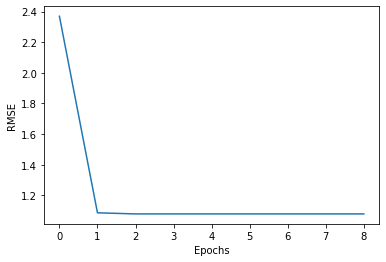

Test RMSE: 1.0861063132198032


In [13]:
g = GMF_Engine(100, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 4933/72800

Epoch 0 (3.969801676273346 min), mse = 5.710504464723251
Epoch 1 (7.7564990520477295 min), mse = 1.1817975305430182
Epoch 2 (11.56291880607605 min), mse = 1.1649126354809647
Epoch 3 (15.336686515808106 min), mse = 1.1649125120142003
Epoch 4 (19.158322958151498 min), mse = 1.164912377985624
Epoch 5 (23.08313754796982 min), mse = 1.1649122424014322
Epoch 6 (26.131961953639983 min), mse = 0.905501779455405


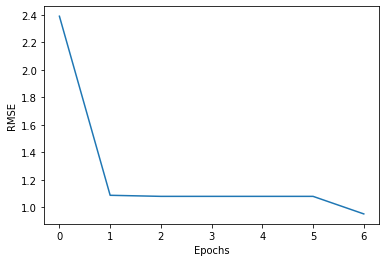

KeyboardInterrupt: ignored

In [14]:
g = GMF_Engine(300, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

In [ ]:
g = GMF_Engine(100, 0.1, 0.9, 65535, 2000)
g.train(train).evaluate(evaluation)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, user_size, movie_size, hidden_size):
        super(MLP, self).__init__()
        self.user_size = user_size
        self.movie_size = movie_size
        self.hidden_size  = hidden_size
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.user_size, embedding_dim=self.hidden_size)
        self.embedding_movie = torch.nn.Embedding(num_embeddings=self.movie_size, embedding_dim=self.hidden_size)

        self.layers = [hidden_size*2, 64,32,16,8]

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=self.layers[-1], out_features=1)

    def forward(self, user_id, movie_id):
        user_embedding = self.embedding_user(user_id)
        movie_embedding = self.embedding_movie(movie_id)
        vector = torch.cat([user_embedding, movie_embedding], dim=-1)  # the concat latent vector

        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)

        output = self.affine_output(vector)
        return output

In [16]:
class MLP_Engine:
    def __init__(self, rank, learning_rate, gamma, batch_size, training_time):
        # model define here
        self.model = MLP(user_count, movie_count, rank)
        self.model = self.model.to(device)
        self.criterion = nn.MSELoss()
        
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=learning_rate, weight_decay=0.0)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        self.rank = rank
        self.batch_size = batch_size

        self.training_time = training_time

    def train(self, ratings):
        data_loader = torch.utils.data.DataLoader(ratings, batch_size=self.batch_size)
        self.model.train()
        history = []
        idx = 0
        epoch = 0
        with Progress(100 * len(data_loader)) as progress:
            start_time = time.time()
            while time.time() - start_time < self.training_time:
                try:
                    mse = 0
                    for batch_idx, batch in enumerate(data_loader):
                        user = batch[:, 0]
                        movie = batch[:, 1]
                        target = batch[:, 2]
                        user = user.to(device)
                        movie = movie.to(device)
                        target = target.to(device)
                        # set the gradients to zero to avoid unwanted gradient accumulation, see 
                        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                        self.optimizer.zero_grad()
                        
                        # get model prediction
                        output = self.model(user, movie)
                        
                        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
                        loss = self.criterion(output.view(-1).float(), target.float())
    
                        mse += float(loss)
                        
                        # perform back propagation
                        loss.backward()
    
                        self.optimizer.step()
                        
                        # update parameters
                        progress.inc()
                except KeyboardInterrupt:
                    break
                finally:
                    history.append(np.sqrt(mse / len(data_loader)))
                    print(f"Epoch {epoch} ({(time.time() - start_time) / 60} min), mse = {mse / len(data_loader)}")
                    epoch += 1

        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(np.arange(epoch), history)
        plt.show()

        return self

    def predict(self, user, movie):
        return float(self.model(torch.Tensor([user]).int().to(device),torch.Tensor([movie]).int().to(device)))

    def evaluate(self, evaluation):
        self.model.eval()
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - float(rating)
            se += err ** 2
        print("Test RMSE: {}".format(np.sqrt(se/len(evaluation))))

[=====                                                       ] 6552/72800

Epoch 0 (3.9541581432024637 min), mse = 1.418470827432779
Epoch 1 (7.920173700650533 min), mse = 1.1984672539836758
Epoch 2 (11.922839550177256 min), mse = 1.1747181723406026
Epoch 3 (15.895838673909505 min), mse = 1.161365117427412
Epoch 4 (19.86888773838679 min), mse = 1.1519537043276724
Epoch 5 (23.880786248048146 min), mse = 1.143737707737383
Epoch 6 (27.897090927759805 min), mse = 1.1343041155691986
Epoch 7 (31.91445514758428 min), mse = 1.1226189937237854
Epoch 8 (35.95400375525157 min), mse = 1.1127701155268228


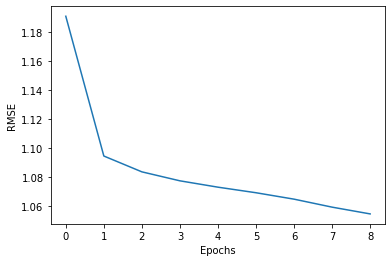

Test RMSE: 1.0787316794561261


In [17]:
g = MLP_Engine(100, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 5824/72800

Epoch 0 (4.364117689927419 min), mse = 1.6029989005445124
Epoch 1 (8.680763459205627 min), mse = 1.179170004941605
Epoch 2 (12.892240683237711 min), mse = 1.1420612107593935
Epoch 3 (17.15731825828552 min), mse = 1.1168153125506182
Epoch 4 (21.440428094069162 min), mse = 1.0999944477782144
Epoch 5 (25.73125698963801 min), mse = 1.087599886233335
Epoch 6 (29.995231540997825 min), mse = 1.0759612377528305
Epoch 7 (34.23746557633082 min), mse = 1.0640583718707273


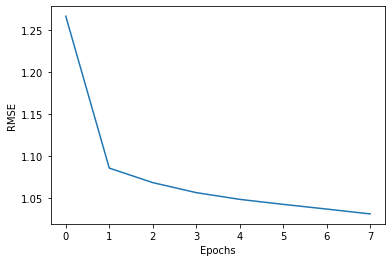

Test RMSE: 1.1110134401440945


In [18]:
g = MLP_Engine(300, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 5824/72800

Epoch 0 (4.188665409882863 min), mse = 2.53485931038529
Epoch 1 (8.363291533788045 min), mse = 1.1997747091310365
Epoch 2 (12.593396385510763 min), mse = 1.1825799251814464
Epoch 3 (16.836560030778248 min), mse = 1.1708441806527286
Epoch 4 (21.051466476917266 min), mse = 1.1621753945946693
Epoch 5 (25.252320973078408 min), mse = 1.1553688091072407
Epoch 6 (29.459993668397267 min), mse = 1.1497484155736126
Epoch 7 (33.659440179665886 min), mse = 1.1449058202433062


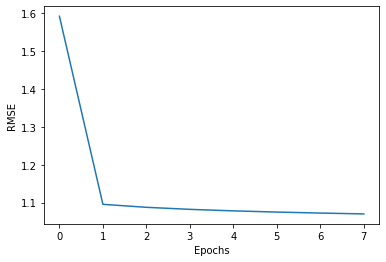

Test RMSE: 1.0837209208021732


In [19]:
g = MLP_Engine(100, 0.1, 0.9, 65535, 2000)
g.train(train).evaluate(evaluation)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class NeuMF(torch.nn.Module):
    def __init__(self, user_size, movie_size, latent_dim_mf, latent_dim_mlp):
        super(NeuMF, self).__init__()
        self.num_users = user_size
        self.num_items = movie_size
        self.latent_dim_mf = latent_dim_mf
        self.latent_dim_mlp = latent_dim_mlp

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.layers = [latent_dim_mlp*2, 64,32,16,8]

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=self.layers[-1] + latent_dim_mf, out_features=1)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat((mlp_vector, mf_vector), dim=-1)
        rating = self.affine_output(vector)
        return rating


In [21]:
class NeuMF_Engine:
    def __init__(self, rank, learning_rate, gamma, batch_size, training_time):
        # model define here
        self.model = NeuMF(user_count, movie_count, rank, rank)
        self.model = self.model.to(device)
        self.criterion = nn.MSELoss()
        
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=learning_rate, weight_decay=0.0)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        self.rank = rank
        self.batch_size = batch_size

        self.training_time = training_time

    def train(self, ratings):
        data_loader = torch.utils.data.DataLoader(ratings, batch_size=self.batch_size)
        self.model.train()
        history = []
        idx = 0
        epoch = 0
        with Progress(100 * len(data_loader)) as progress:
            start_time = time.time()
            while time.time() - start_time < self.training_time:
                try:
                    mse = 0
                    for batch_idx, batch in enumerate(data_loader):
                        user = batch[:, 0]
                        movie = batch[:, 1]
                        target = batch[:, 2]
                        user = user.to(device)
                        movie = movie.to(device)
                        target = target.to(device)
                        # set the gradients to zero to avoid unwanted gradient accumulation, see 
                        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                        self.optimizer.zero_grad()
                        
                        # get model prediction
                        output = self.model(user, movie)
                        
                        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
                        loss = self.criterion(output.view(-1).float(), target.float())
    
                        mse += float(loss)
                        
                        # perform back propagation
                        loss.backward()
    
                        self.optimizer.step()
                        
                        # update parameters
                        progress.inc()
                except KeyboardInterrupt:
                    break
                finally:
                    history.append(np.sqrt(mse / len(data_loader)))
                    print(f"Epoch {epoch} ({(time.time() - start_time) / 60} min), mse = {mse / len(data_loader)}")
                    epoch += 1

        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(np.arange(epoch), history)
        plt.show()

        return self

    def predict(self, user, movie):
        return float(self.model(torch.Tensor([user]).int().to(device),torch.Tensor([movie]).int().to(device)))

    def evaluate(self, evaluation):
        self.model.eval()
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - float(rating)
            se += err ** 2
        print("Test RMSE: {}".format(np.sqrt(se/len(evaluation))))

[====                                                        ] 5824/72800

Epoch 0 (4.402714423338572 min), mse = 1.5089814916744337
Epoch 1 (8.783077597618103 min), mse = 1.188915023109415
Epoch 2 (13.177910538514455 min), mse = 1.1685226119972847
Epoch 3 (17.56034120718638 min), mse = 1.1577779802974764
Epoch 4 (21.936864511171976 min), mse = 1.1500752186709708
Epoch 5 (26.336548479398093 min), mse = 1.141903973215229
Epoch 6 (30.735320258140565 min), mse = 1.132976604441365
Epoch 7 (35.113500436147056 min), mse = 1.123277682196963


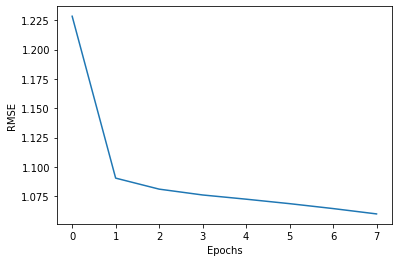

Test RMSE: 1.0848390057387018


In [22]:
g = NeuMF_Engine(100, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 5824/72800

Epoch 0 (4.6540641983350115 min), mse = 1.5882337919467098
Epoch 1 (9.330087331930796 min), mse = 1.150916803914767
Epoch 2 (14.022684033711752 min), mse = 1.119980965259966
Epoch 3 (18.6810178955396 min), mse = 1.1004156302456016
Epoch 4 (23.329402140776317 min), mse = 1.085698327766015
Epoch 5 (28.006371800104777 min), mse = 1.0746624868485954
Epoch 6 (32.669062670071916 min), mse = 1.0642582184665805
Epoch 7 (37.31748586893082 min), mse = 1.0548100605770783


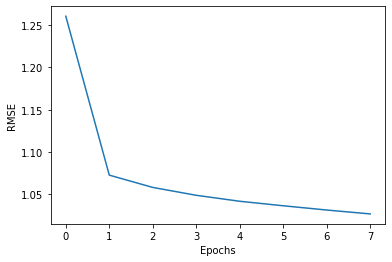

Test RMSE: 1.0903830638399918


In [23]:
g = NeuMF_Engine(300, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 5824/72800

Epoch 0 (4.464522063732147 min), mse = 2.4444334193409145
Epoch 1 (8.891016578674316 min), mse = 1.1960241679961865
Epoch 2 (13.249180018901825 min), mse = 1.1776497596567803
Epoch 3 (17.617920017242433 min), mse = 1.1650713759955469
Epoch 4 (22.02969563404719 min), mse = 1.1556796029537588
Epoch 5 (26.38392988840739 min), mse = 1.148249401168509
Epoch 6 (30.733140925566357 min), mse = 1.1421288971553791
Epoch 7 (35.04097121159236 min), mse = 1.136927156002967


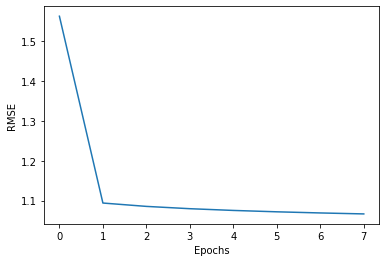

Test RMSE: 1.085369129781817


In [24]:
g = NeuMF_Engine(100, 0.1, 0.9, 65535, 2000)
g.train(train).evaluate(evaluation)